# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [86]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

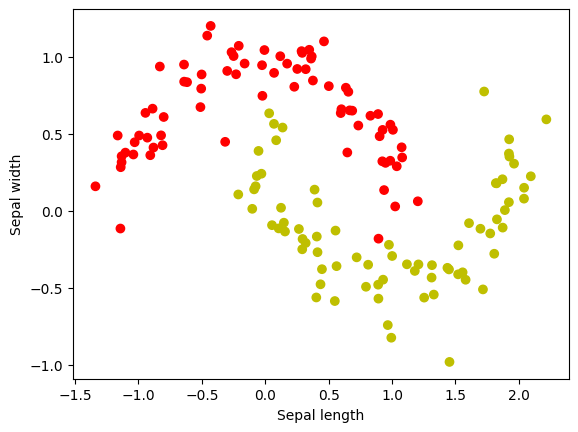

In [87]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [88]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [89]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [90]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [91]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [92]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.0010)


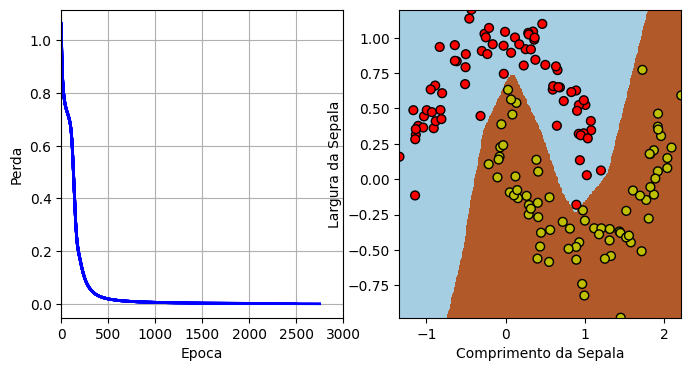

In [93]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(X_tensor)

    loss = criterion(output, Y_tensor)

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [94]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([10, 2])
tensor([[-0.6213,  1.0136],
        [-0.4818,  0.0185],
        [ 0.2688, -0.1288],
        [-1.3433, -0.0700],
        [ 0.0295, -0.1907],
        [ 0.3306, -1.0525],
        [-1.5768,  0.6765],
        [ 1.2919,  0.1272],
        [ 0.9030,  1.1224],
        [ 1.5201, -0.4085]])
dense.0.bias    torch.Size([10])
tensor([-0.0776,  1.2149, -0.6261,  0.0862, -0.4181, -0.3327, -0.3161, -0.1608,
        -0.1524, -1.4304])
dense.2.weight  torch.Size([10, 10])
tensor([[-0.1197, -0.8132,  0.3041,  0.0499, -0.1127,  0.6516, -0.1280,  0.8471,
          0.1212,  1.3792],
        [ 0.1855, -0.1626,  0.2177,  0.1309,  0.1441,  0.0872,  0.1192,  0.0518,
         -0.1659,  0.0180],
        [ 0.2585,  0.7946,  0.2406, -0.4238, -0.1040,  0.6560, -1.0626, -0.6691,
         -0.8647,  0.4050],
        [ 0.0298, -0.2480, -0.1699, -0.1389, -0.0281, -0.1922,  0.2802,  0.1766,
         -0.2253,  0.0585],
        [ 0.7220,  0.2229, -0.2343,  0.3915, -0.1026, -0.1631,  0.4479

### Avaliação do classificador

In [95]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  1.0


### Matriz de confusão

In [96]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,75,0
1,0,75


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.
- Ao aumentar a número de neurônios nas duas camadas ocultas existentes, o modelo performou muito bem no treinamento e atingiu uma acurácia de 99,3%, uma vez que provavelmente conseguiu extrar mais características dos dados.
- Ao permanecer com a adição de neurônios anterior e adicionar mais uma camada oculta, o modelo performou ainda melhor, com acurácia de 100%. Isso parece ser ótimo, mas exige cuidados, pois pode configurar overfitting ao modelo. Para verificar isto, o ideal seria comparar a perda entre conjunto de treino e o de teste, e caso o overfitting fosse de fato constatado, uma sugestão seria fazer a regularização com Dropout.
2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.
- Com ReLu, foi possível fazer uma separação não linear dos dados, o que faz sentido para a natureza dos dados do dataset em questsão. A perda final foi de 0,0217 e a acurácia de 98,6%.

- Com Sigmoide como camada de ativação no lugar da ReLu, não foi posśivel fazer uma separação não linear dos dados, pois houve Vanishing Gradient, ou seja, a função sigmoide provavelmente saturou rapidamente e causou um enfraquecimento dos gradientes, limitando o modelo a uma capacidade linear não complexa. A perda final foi de 0,2848 e a acurácia de 88%.}
3. O que ocorre quando não se utiliza ativação não linear entre camadas?
- Como as demais camadas da rede neural em questão são lineares, então a separação dos dados (fronteiras) continuará sendo linear.